In [8]:
import numpy as np
import arviz as az
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
from pickle import load
from scipy.stats import pearsonr
plt.style.use('ggplot')
matplotlib.rcParams.update({'font.size': 11})

### Convergence diagnostics

In [2]:
trace_ngram = az.from_netcdf('traces/trace_ngram.nc')
trace_lstm = az.from_netcdf('traces/trace_lstm.nc')
trace_gpt2 = az.from_netcdf('traces/trace_gpt2.nc')

In [3]:
def plot_convergence(trace, ax, color, label):
    summary = pd.DataFrame(az.summary(trace, round_to=4))

    r_hats = summary['r_hat'].values
    ess = summary['ess_bulk'].values
    ax.scatter(r_hats, ess, color=color, alpha=.8, label=label)


/home/davide/anaconda3/envs/Bayesian_project/lib/python3.9/site-packages/arviz/stats/diagnostics.py:586: RuntimeWarning: invalid value encountered in double_scalars
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/home/davide/anaconda3/envs/Bayesian_project/lib/python3.9/site-packages/arviz/stats/diagnostics.py:586: RuntimeWarning: invalid value encountered in double_scalars
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/home/davide/anaconda3/envs/Bayesian_project/lib/python3.9/site-packages/arviz/stats/diagnostics.py:586: RuntimeWarning: invalid value encountered in double_scalars
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/home/davide/anaconda3/envs/Bayesian_project/lib/python3.9/site-packages/arviz/stats/diagnostics.py:586: RuntimeWarning: invalid value encountered in double_scalars
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


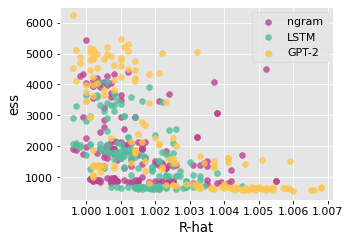

In [4]:
fig, ax = plt.subplots(figsize=(5, 3.5))
plot_convergence(trace_ngram, ax=ax, color='#BD4291', label='ngram')
plot_convergence(trace_lstm, ax=ax, color='#53BF9D', label='LSTM')
plot_convergence(trace_gpt2, ax=ax, color='#FFC54D', label='GPT-2')
ax.legend(loc='upper right')
ax.tick_params(axis='both', colors='k')
ax.set_xlabel('R-hat', color='k')
ax.set_ylabel('ess', color='k')
plt.tight_layout()
plt.savefig('images/diagnostics.pdf')

### Model comparison

LOO-elpd comparison

In [ ]:
with open('loos.pkl', 'rb') as f:
    loos = load(f)
loos

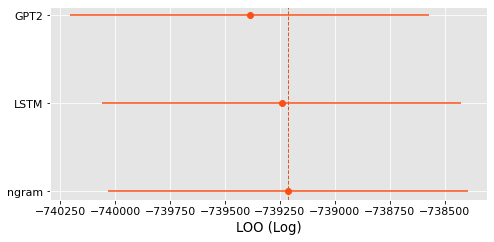

In [11]:
means = loos.loo.values
errs = loos.se.values

fig, ax = plt.subplots(figsize=(7, 3.5))
ax.errorbar(x=means, y=np.arange(3), xerr=errs, fmt='o', c='#FB4F14')
ax.set_yticks(np.arange(3))
ax.set_yticklabels(['ngram', 'LSTM', 'GPT2'], c='k')
ax.axvline(x=means[0], ls='--', lw=1, c='#e25822')
ax.set_xlabel('LOO (Log)', c='k')
ax.tick_params(axis='both', colors='k')
plt.tight_layout()
plt.savefig('images/comparison.pdf')

Pointwise LOO comparison

In [12]:
loo_ngram = np.load('loo_ngram.npy', allow_pickle=True)
loo_lstm = np.load('loo_lstm.npy',allow_pickle=True)
loo_gpt2 = np.load('loo_gpt2.npy',allow_pickle=True)
df = pd.read_csv('df_ngram.csv')

In [15]:
df['loo_ngram'] = loo_ngram
df['loo_lstm'] = loo_lstm
df['loo_gpt2'] = loo_gpt2

In [17]:
surp_ngram = np.load('surp.npy')
surp_lstm = np.load('surp_lstm.npy')
surp_gpt2 = np.load('surp_gpt2.npy')

In [18]:
c_lg = pearsonr(surp_lstm, surp_gpt2)[0]
c_ln = pearsonr(surp_lstm, surp_ngram)[0]
c_gn = pearsonr(surp_gpt2, surp_ngram)[0]
corrs = [c_lg, c_ln, c_gn]

In [19]:
l_lg = df.loo_lstm.sum() - df.loo_gpt2.sum()
l_ln = df.loo_ngram.sum() - df.loo_lstm.sum()
l_gn = df.loo_ngram.sum() - df.loo_gpt2.sum()
loo_diff = [l_lg, l_ln, l_gn]

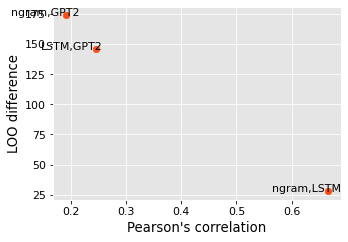

In [20]:
txts = ['LSTM,GPT2', 'ngram,LSTM', 'ngram,GPT2']
fig, ax = plt.subplots(figsize=(5,3.5))
ax.scatter(corrs, loo_diff, marker='8', c='#FB4F14', s=50)
ax.set_ylabel('LOO difference', c='k')
ax.set_xlabel('Pearson\'s correlation', c='k')
for i, txt in enumerate(txts):
    ax.annotate(txt, (corrs[i], loo_diff[i]), c='k', xytext=(corrs[i]-0.1, loo_diff[i]))
ax.tick_params(axis='both', colors='k')
plt.tight_layout()
plt.savefig('images/corr_loo.pdf')

